In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet

dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index(dir_parts[-2])
root_dir = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_dir + '/LensFinding/src/')
import src.data.data_utils as data_utils
import src.hparam_tuning as tuning
import src.utils as utils
from src.data.lensfinding_dataset import LensFindingDataset
from src.training.solver import Solver

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Specific Test II - Lens Finding

In this notebook, we build a PyTorch model to solve the specific test number II for lens finding. 

We are going to use a simple Residual Neural Network (ResNet) [[He et al., 2016](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)]. Indeed, more complex architectures (e.g., DenseNet, Vision Transformers) would have been viable options, and possibly provide better results. However, they are also more computationally expensive. Thus, for simplicity, we stick to a relatively small ResNet18.

## Preparation

### Dataset

Let us load the lens finding dataset via PyTorch dataloaders. Specifically, we will load the original (full) training set, the train-validation splits that will be used for model selection, and the test set that will be used to assess model performance.

Before delving deeper, let's define some useful variables.

### Settings

In [3]:
# Dataset settings
DATASET_NAME = 'lensfinding'
N_CLASSES = 2

# Dataloaders settings
BATCH_SIZE = 256
VAL_SPLIT = 0.2 # the percentage of training data to be used as validation
RANDOM_STATE = 42 # for reproducibility
STRETCH = True # whether to apply square root stretch or not

Now, let us instatiate the dataloaders.

We apply a square-root stretch to (possibly) enhance features with lower surface brightness [[Rezaie et al., 2024](https://arxiv.org/html/2502.14936v1)]. During our model selection we observed slighly better performance when this pre-processing step was applied.

To obtain train-val splits for model selection, we perform a stratified split on the original training set. Stratified splitting ensures the original class distribution and will be particularly useful to tackle class imbalance within our dataset. In fact, thanks to the task's description, we know that the dataset is heavily skewed towards non-lenses samples.

### Dataloaders

In [4]:
full_train_dataloader, train_dataloader, val_dataloader, test_dataloader = data_utils.get_dataloaders(
    root_dir=f'datasets/{DATASET_NAME}',
    dataset_class=LensFindingDataset,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    random_state=RANDOM_STATE,
    stretch=STRETCH,
)
_, i_c, h, w = next(iter(train_dataloader))[0].shape
assert i_c == 3, 'Expected one input channel'
assert h == w, 'Expected same width/height as spatial dimensions'
assert h == 64, 'Expected spatial dimensions of 64'

Below we visualize the class distributions in the (original) training set and in the test set. 

Data is considerably imbalanced, with the number of non-lenses surpassing that of strong lenses by one order of magnitude. To tackle class imbalance we will employ a very simple approach: a weighted loss function.

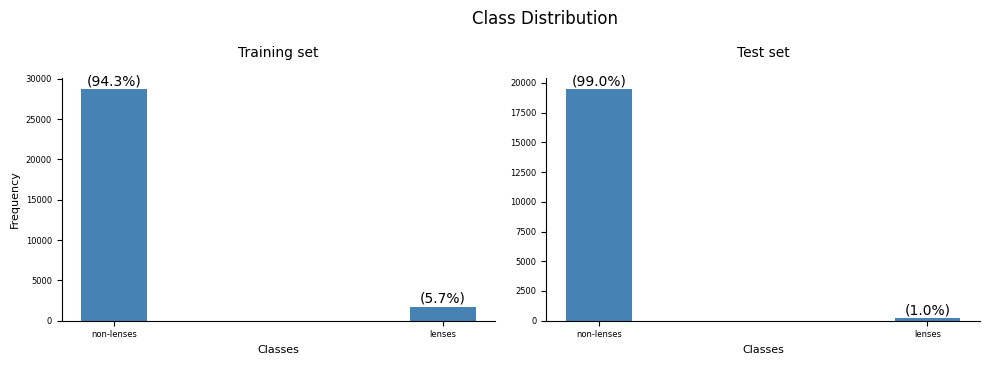

In [5]:
utils.plot_class_distributions(
    dataloaders=(full_train_dataloader, test_dataloader),
    dataloader_names=('Training', 'Test'),
    class_names=['non-lenses', 'lenses'],
)

A weighted loss function addresses class imbalance by assigning higher penalties (weights) to minority classes. The goal is to prevent the model from being biased toward the majority class.

Since we're working with classification, we use PyTorch's CrossEntropyLoss with the weight parameter to assign different penalties to each class. To properly counterbalance class imbalance, weights are computed as the inverse of class frequencies:

$$ w_i = \frac{1}{f_i} $$

where $w_i$ is the penalty for class $i$ and $f_i$ is the frequency of class $i$. This ensures minority classes receive higher importance during training, while majority classes are penalized.

Therefore, let us define our define our weighted loss function.

In [6]:
def get_class_weights(train_dataloader: torch.utils.data.DataLoader) -> torch.Tensor:
    """Counts frequency of each class"""
    class_counts = torch.zeros(2) # we have 2 classes
    for _, labels in train_dataloader:
        for label in labels:
            class_counts[label] += 1
    
    # Calculate inverse frequency weights
    total_samples = class_counts.sum()
    class_weights = total_samples / (2 * class_counts)  # 2 * to normalize
    
    return class_weights

penalties = get_class_weights(full_train_dataloader)
weighted_criterion = torch.nn.CrossEntropyLoss(weight=penalties.to(device))

### Model

As ResNet18 was originally designed to process the ImageNet dataset, we need to adapt the first and last layer of the PyTorch implementation.
Let us define the following method to instantiate our model.

In [7]:
def get_model() -> nn.Module:
    model = resnet.resnet18()
    model.conv1 = nn.Conv2d(i_c, 64, kernel_size=7, stride=2, padding=3, bias=False) # modify input convolution to process <i_c>-channel inputs
    model.fc = nn.Linear(in_features=512, out_features=N_CLASSES, bias=True) # modify output fully-connected layer to predict <N_CLASSES>
    
    return model

## Model Selection

Model selection is carried out via grid-search, as the search space is not excessively large. We leverage the $80-20$ train-val split obtained from the original training set. In particular, different hyperparamaters' configurations will be trained on the training split and tested on the validation split.

We employ an $Adam$ optimizer with PyTorch default momentum values, and a linear decay learning rate scheduler. An early-stopping mechanism is employed so that training may be stopped when performance on the validation set stops improving for a number of epochs specified by $patience$. Finally, in this case we also pass our (custom) weighted loss to our tuner.

Training is performed for a maximum number of $100$ epochs, with patience value of $10$. Results are averaged across $5$ different trials.

In [8]:
# Wandb settings
PROJECT_ENTITY = 'gsoc'
MODEL_NAME = 'resnet18'
wandb_project_name = f'{MODEL_NAME}-{DATASET_NAME.lower()}'

In [9]:
grid_search_configs = {
    'apply_sqrt_stretch': {
        'values': [STRETCH]
    },
    'optimizer': {
        'values': ['Adam']
    },
    'lr': {
        'values': [1e-02, 5e-02, 1e-03, 5e-03, 1e-04]
    },
    'lr_decay': {
        'values': [1e-04, 5e-04, 1e-05, 5e-05, 1e-06]
    },
    'trial_id': {
        'values': [1, 2, 3, 4, 5]
    },
}

tuner = tuning.Tuner(
    device=device,
    project_name=wandb_project_name,
    project_entity=PROJECT_ENTITY,
    model_fn=get_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    configs=grid_search_configs,
    criterion=weighted_criterion,
    epochs=100,
    patience=10,
)
#sweep_id = tuner.run(method='grid') # uncomment if you wish to repeat model selection

## Training

Once the best configuration has been selected via model selection, we perform a final retraining on the entire training set and assess model performance on the test set.

Since we want the evaluation on the test set to be "blind," we cannot use it to perform early stopping. Therefore, the value of $patience$ is set to $None$. To determine a good amount of training epochs when early-stopping cannot be employed,we compute the average epoch on which the best validation performance was achieved during model selection for the current hyperparameters' configuration, and use that as the number of training epochs for the final retraining.

In [10]:
# Best configuration found during model selection
hparams = {
    'apply_sqrt_stretch': True,
    'lr': 0.001,
    'lr_decay': 1e-06 
}

In [11]:
# Create the model
model = get_model()

# Training
solver = Solver(
    device=device,
    model=model,
    train_dataloader=full_train_dataloader,
    val_dataloader=test_dataloader,
    criterion=weighted_criterion,
    lr=hparams['lr'],
    lr_decay=hparams['lr_decay']
)
#solver.train(epochs=30, log=False) # uncomment if you wish to train a new model

In [12]:
# Store model weights at the last epoch
#outf = f'weights/{DATASET_NAME}/weights.pth'
#print(f"Model weights saved to... {outf}")
#torch.save(solver.model.state_dict(), outf)

## Testing

Let us load the previously saved model weights. Then, we evaluate the model on the test set.

In [13]:
from sklearn.metrics import classification_report, roc_auc_score

# Load model weights
model = get_model()
model.load_state_dict(torch.load(f'weights/{DATASET_NAME}/weights.pth', weights_only=True))

# Predict on the test set
model.to(device)
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():  # Add this to prevent gradient calculation during validation
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        all_labels.extend(labels.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
        all_preds.append(probs)

all_labels = np.array(all_labels)
all_preds = np.vstack(all_preds)
n_classes = all_preds.shape[1]

Below we visualize the performance obtained on the test set. In particular, the classification report gives us in-depth insights into how the models performs on each class.

In [14]:
test_auc = roc_auc_score(all_labels, all_preds[:, 1])
print(f"Test AUC: {test_auc:.4f}")
print(classification_report(all_labels, np.argmax(all_preds, axis=1)))

Test AUC: 0.9781
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19455
           1       0.39      0.77      0.52       195

    accuracy                           0.99     19650
   macro avg       0.69      0.88      0.76     19650
weighted avg       0.99      0.99      0.99     19650



Finally, we plot the ROC curve (left), and a confusion matrix (right).

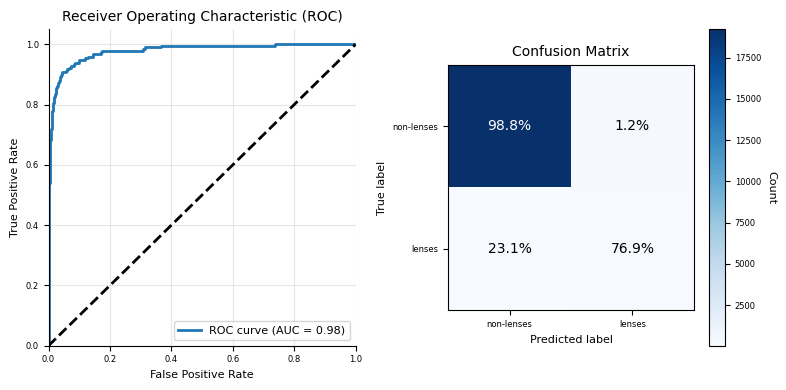

In [15]:
utils.plot_predictions(all_labels, all_preds, ['non-lenses', 'lenses'])